In [20]:
# Install the necessary libraries
from __future__ import print_function, division


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

plt.ion()

In [2]:
# Define Data Transforms

data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}


In [ ]:
# Download the Dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [3]:
# unzip the dataset
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

  inflating: hymenoptera_data/train/bees/129236073_0985e91c7d.jpg  
  inflating: hymenoptera_data/train/bees/1295655112_7813f37d21.jpg  
  inflating: hymenoptera_data/train/bees/132511197_0b86ad0fff.jpg  
  inflating: hymenoptera_data/train/bees/132826773_dbbcb117b9.jpg  
  inflating: hymenoptera_data/train/bees/150013791_969d9a968b.jpg  
  inflating: hymenoptera_data/train/bees/1508176360_2972117c9d.jpg  
  inflating: hymenoptera_data/train/bees/154600396_53e1252e52.jpg  
  inflating: hymenoptera_data/train/bees/16838648_415acd9e3f.jpg  
  inflating: hymenoptera_data/train/bees/1691282715_0addfdf5e8.jpg  
  inflating: hymenoptera_data/train/bees/17209602_fe5a5a746f.jpg  
  inflating: hymenoptera_data/train/bees/174142798_e5ad6d76e0.jpg  
  inflating: hymenoptera_data/train/bees/1799726602_8580867f71.jpg  
  inflating: hymenoptera_data/train/bees/1807583459_4fe92b3133.jpg  
  inflating: hymenoptera_data/train/bees/196430254_46bd129ae7.jpg  
  inflating: hymenoptera_data/train/bees/1966

  inflating: hymenoptera_data/val/ants/2127908701_d49dc83c97.jpg  
  inflating: hymenoptera_data/val/ants/2191997003_379df31291.jpg  
  inflating: hymenoptera_data/val/ants/2211974567_ee4606b493.jpg  
  inflating: hymenoptera_data/val/ants/2219621907_47bc7cc6b0.jpg  
  inflating: hymenoptera_data/val/ants/2238242353_52c82441df.jpg  
  inflating: hymenoptera_data/val/ants/2255445811_dabcdf7258.jpg  
  inflating: hymenoptera_data/val/ants/239161491_86ac23b0a3.jpg  
  inflating: hymenoptera_data/val/ants/263615709_cfb28f6b8e.jpg  
  inflating: hymenoptera_data/val/ants/308196310_1db5ffa01b.jpg  
  inflating: hymenoptera_data/val/ants/319494379_648fb5a1c6.jpg  
  inflating: hymenoptera_data/val/ants/35558229_1fa4608a7a.jpg  
  inflating: hymenoptera_data/val/ants/412436937_4c2378efc2.jpg  
  inflating: hymenoptera_data/val/ants/436944325_d4925a38c7.jpg  
  inflating: hymenoptera_data/val/ants/445356866_6cb3289067.jpg  
  inflating: hymenoptera_data/val/ants/459442412_412fecf3fe.jpg  
  inf

In [4]:
# Source Data Directory
data_dir = 'hymenoptera_data/'

# Load from directory to datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),
                                         data_transforms[x])

                  for x in (['train','val'])}


# Load the datasets as DataLoaders
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True,num_workers=8)

                for x in (['train','val'])}

# Dataset size
dataset_sizes = {x : len(image_datasets[x]) for x in ['train','val']}


# Labels definition
class_names = image_datasets['train'].classes

In [5]:
# GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
# Image visualzier utility function
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean #convert normalised to raw
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

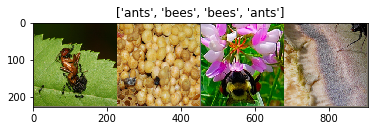

In [7]:
# Get a batch of training data
inputs, classes = next(iter(data_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
# Load the pretrained model

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features



model_ft.fc = nn.Linear(num_ftrs,len(class_names))
model_ft = model_ft.to(device)
crieterion = nn.CrossEntropyLoss()


# Observe that all parameters are being optimized
optimiser_ft = optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimiser_ft,step_size=7,gamma=0.1)

In [9]:
# Training Script
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())  #state- extract only weights from model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)              # feed - forwarding
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()   # alpha(scheduler) -> learning_rate
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
# Train the model

model_ft = train_model(model_ft,crieterion,optimiser_ft,exp_lr_scheduler,num_epochs=15)


Epoch 0/14
----------
train Loss: 0.7655 Acc: 0.6721
val Loss: 0.2684 Acc: 0.9020

Epoch 1/14
----------
train Loss: 0.5810 Acc: 0.7705
val Loss: 0.5308 Acc: 0.8170

Epoch 2/14
----------
train Loss: 0.5334 Acc: 0.7951
val Loss: 0.3032 Acc: 0.9281

Epoch 3/14
----------
train Loss: 0.5657 Acc: 0.8033
val Loss: 0.1928 Acc: 0.9477

Epoch 4/14
----------
train Loss: 0.7583 Acc: 0.7582
val Loss: 0.4780 Acc: 0.8431

Epoch 5/14
----------
train Loss: 0.6823 Acc: 0.7623
val Loss: 0.4740 Acc: 0.8170

Epoch 6/14
----------
train Loss: 0.4714 Acc: 0.8197
val Loss: 0.5541 Acc: 0.8366

Epoch 7/14
----------
train Loss: 0.4214 Acc: 0.8361
val Loss: 0.3793 Acc: 0.8627

Epoch 8/14
----------
train Loss: 0.4269 Acc: 0.7992
val Loss: 0.3504 Acc: 0.8627

Epoch 9/14
----------
train Loss: 0.4687 Acc: 0.8115
val Loss: 0.3282 Acc: 0.8693

Epoch 10/14
----------
train Loss: 0.2658 Acc: 0.8689
val Loss: 0.2741 Acc: 0.8824

Epoch 11/14
----------
train Loss: 0.3250 Acc: 0.8607
val Loss: 0.2602 Acc: 0.9020

Ep

In [14]:
# Evaluation Script
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

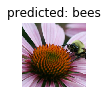

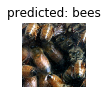

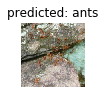

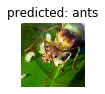

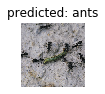

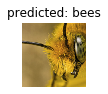

In [15]:
# Run Visualizer
visualize_model(model_ft)

In [21]:
# Save the model 
torch.save(model_ft,'webtry.pth')

//anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
//anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
//anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
//anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
//anaconda3/lib/python3.7

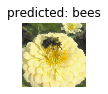

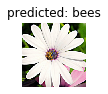

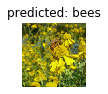

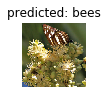

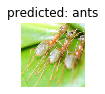

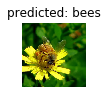

In [18]:
# To check model works fine ,load it
test_model = torch.load('webtry.pth')
test_model.eval()
visualize_model(test_model)


